# Preprocessing steps for Raman data

1. Data merging
2. Baseline correction


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from numpy.polynomial.polynomial import Polynomial
%config InlineBackend.figure_format = 'svg'

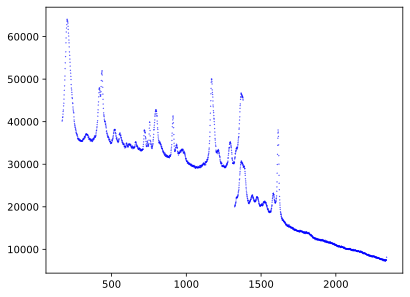

In [41]:
# Plotting the data from the file
data = [list(map(float, line.split())) for line in open(r'Data\merged roughly\merged roughly 5\(5)_7__X_4.2__Y_26.3.txt')]
x, y = zip(*data)

plt.scatter(x, y, facecolors='none', edgecolors='blue', s=0.1, marker='o')
plt.show()

🔧 Enforced baseline ≤ signal at 138 points.
✅ No negatives detected. No shift needed.


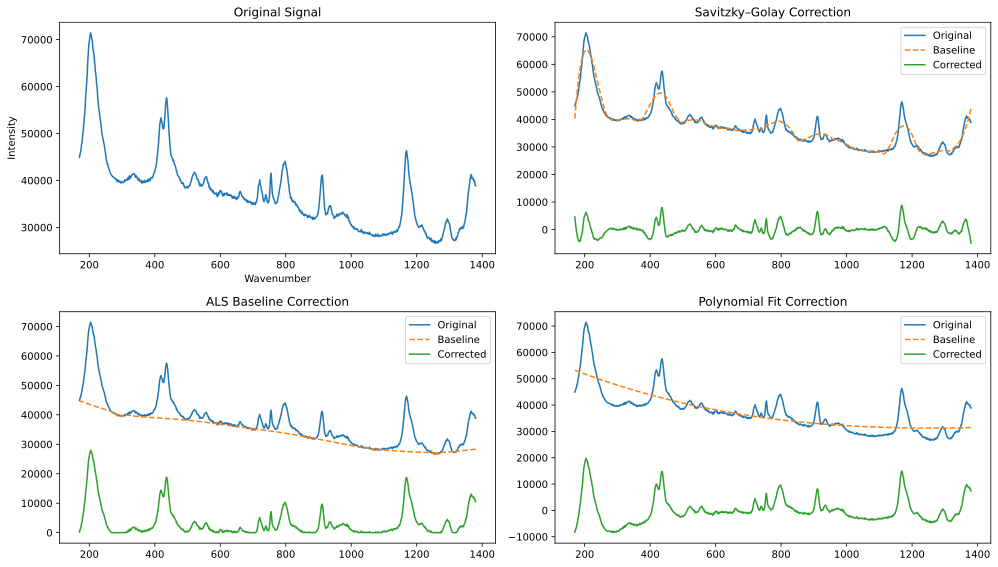

In [ ]:
# ---------- Baseline Correction for Raman Spectroscopy ----------
# ---------- Load Your Raman Data ----------
# Replace with your actual path
data = np.loadtxt('Data/5-1/(5)-11_0__X_4.2__Y_35.4__ElapsedTime_0.txt', skiprows=0)  # change filename if needed

x = data[:, 0]  # Wavenumber (X-axis)
y = data[:, 1]  # Intensity (Y-axis)

# ---------- 1. Savitzky–Golay Baseline ----------
def baseline_savgol(y, window=101, poly=3):
    baseline = savgol_filter(y, window_length=window, polyorder=poly)
    return y - baseline, baseline

# ---------- 2. ALS Baseline ----------
def baseline_als_final(y, lam=1e6, p=0.01, niter=10, debug=False):
    """
    Final version of ALS baseline correction:
    - Allows full ALS freedom
    - Ensures baseline doesn't overshoot signal
    - Checks final corrected signal for negatives and shifts baseline if needed
    """
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    import numpy as np

    y = np.array(y)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)

    # Step 1: Run standard ALS
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D @ D.T
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)

    # Step 2: Enforce baseline stays below signal
    mask = z > y
    if np.any(mask):
        z[mask] = y[mask]
        if debug:
            print(f"🔧 Enforced baseline ≤ signal at {np.sum(mask)} points.")

    corrected = y - z

    # Step 3: Final safety — correct if any negatives remain
    if np.any(corrected < 0):
        min_val = np.min(corrected)
        z += abs(min_val)
        corrected = y - z
        if debug:
            print(f"✅ Final adjustment: shifted baseline by {abs(min_val):.4f} to remove negatives.")

    else:
        if debug:
            print("✅ No negatives detected. No shift needed.")

    return corrected, z


# ---------- 3. Polynomial Fit ----------
def baseline_poly(x, y, deg=3):
    coeffs = Polynomial.fit(x, y, deg).convert().coef
    baseline = np.polyval(list(reversed(coeffs)), x)
    return y - baseline, baseline

# ---------- Apply Corrections ----------
y_savgol, b_sg = baseline_savgol(y)
y_als, b_als = baseline_als_final(y, debug=True)
y_poly, b_poly = baseline_poly(x, y)

# ---------- Plot Comparison ----------
plt.figure(figsize=(14, 8))

# Original
plt.subplot(2, 2, 1)
plt.plot(x, y, label='Original')
plt.title("Original Signal")
plt.xlabel("Wavenumber")
plt.ylabel("Intensity")

# Savitzky–Golay
plt.subplot(2, 2, 2)
plt.plot(x, y, label='Original')
plt.plot(x, b_sg, '--', label='Baseline')
plt.plot(x, y_savgol, label='Corrected')
plt.title("Savitzky–Golay Correction")
plt.legend()

# ALS
plt.subplot(2, 2, 3)
plt.plot(x, y, label='Original')
plt.plot(x, b_als, '--', label='Baseline')
plt.plot(x, y_als, label='Corrected')
plt.title("ALS Baseline Correction")
plt.legend()

# Polynomial Fit
plt.subplot(2, 2, 4)
plt.plot(x, y, label='Original')
plt.plot(x, b_poly, '--', label='Baseline')
plt.plot(x, y_poly, label='Corrected')
plt.title("Polynomial Fit Correction")
plt.legend()

plt.tight_layout()
plt.show()


Future work: There is a problem of ALS with negative values. Yes, there is no negative values anymore but it seems like it is overfitting at that parts.
1. Be sure there is no negative balues for the intensity
2. Be sure it is not overfitting, capturing the general trends 
3. Be sure that this ALS baseline correction works properly for all the other Raman data

## Checking the range of the data on 1 file
- This part is extension part. Do not follow the rest of the preprocessing part
- Can be removed w/o causing any error

In [44]:
data = [list(map(float, line.split())) for line in open(r'Data\merged roughly\merged roughly 7\(7)_4__X_4.2__Y_30.2.txt')]
x, y = zip(*data)
# Calculate ranges
x_range = (min(x), max(x))  # Wavenumber range (cm⁻¹)
y_range = (min(y), max(y))  # Intensity range

# Print results
print(f"Wavenumber range: {x_range[0]:.2f} to {x_range[1]:.2f} cm⁻¹")
print(f"Intensity range: {y_range[0]:.2f} to {y_range[1]:.2f} (arb. units)")

# Optional: Check wavenumber step sizes
steps = np.diff(x)
print(f"\nWavenumber step statistics:")
print(f"Min step: {np.min(steps):.4f} cm⁻¹")
print(f"Max step: {np.max(steps):.4f} cm⁻¹")
print(f"Avg step: {np.mean(steps):.4f} cm⁻¹")

Wavenumber range: 169.84 to 2339.42 cm⁻¹
Intensity range: 667.21 to 5767.81 (arb. units)

Wavenumber step statistics:
Min step: 0.2200 cm⁻¹
Max step: 1.3180 cm⁻¹
Avg step: 1.0693 cm⁻¹


### Renaming the datasets
- This part is extension part. Do not follow the rest of the preprocessing part
- Can be removed w/o causing any error

In [ ]:
import os
import re

def rename_files(folder_path):
    """
    Renames files in the specified folder, handling two formats:
    1. Original format: (5)-11_4__X_4.2__Y_30.2__ElapsedTime_1.txt
       -> (5)-1_4__X_4.2__Y_30.2.txt
    2. New format: (6)-1_0_X_4.2_Y_35.4_ElapsedTime_0.txt
       -> (6)-1_0_X_4.2_Y_35.4.txt
    """
    # Regex patterns to match both filename formats
    pattern1 = re.compile(r'^\((\d+)\)-(\d+)_(\d+)__X_([\d\.-]+)__Y_([\d\.-]+)__ElapsedTime_\d+(\.\w+)?$')
    pattern2 = re.compile(r'^\((\d+)\)-(\d+)_(\d+)_X_([\d\.-]+)_Y_([\d\.-]+)_ElapsedTime_\d+(\.\w+)?$')
    
    for filename in os.listdir(folder_path):
        match1 = pattern1.match(filename)
        match2 = pattern2.match(filename)
        
        if match1:
            # Handle original format with double underscores
            group_num = match1.group(1)  # The '5' in (5)
            first_num = match1.group(2)  # The '11' part
            second_num = match1.group(3)  # The '4' part
            x_val = match1.group(4)      # X value (e.g., 4.2)
            y_val = match1.group(5)      # Y value (e.g., 30.2)
            ext = match1.group(6) or '.txt'  # File extension
            
            # Take just the first digit of the first number
            new_first_num = first_num[0]
            
            # Construct new filename (keeping original double underscore format)
            new_filename = f"({group_num})-{new_first_num}_{second_num}__X_{x_val}__Y_{y_val}{ext}"
            
        elif match2:
            # Handle new format with single underscores
            group_num = match2.group(1)  # The '6' in (6)
            first_num = match2.group(2)  # The '1' part
            second_num = match2.group(3)  # The '0' part
            x_val = match2.group(4)      # X value (e.g., 4.2)
            y_val = match2.group(5)      # Y value (e.g., 35.4)
            ext = match2.group(6) or '.txt'  # File extension
            
            # Construct new filename (keeping single underscore format)
            new_filename = f"({group_num})-{first_num}_{second_num}_X_{x_val}_Y_{y_val}{ext}"
            
        else:
            print(f"Skipped (no match): {filename}")
            continue
            
        # Full paths
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, new_filename)
        
        # Rename the file
        try:
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")
        except Exception as e:
            print(f"Error renaming {filename}: {str(e)}")




target_folder = r"Data/6-1 copy"  # Raw string for Windows paths
rename_files(target_folder)

## Merging codes - Brute merge (without checking overlapping or not connected data)
- This part is extension part. Do not follow the rest of the preprocessing part
- Can be removed w/o causing any error

In [ ]:
import os
import shutil

def merge_matching_files(data_root_folder):
    # Create the main merged folder if it doesn't exist
    merged_root = os.path.join(data_root_folder, "merged roughly")
    os.makedirs(merged_root, exist_ok=True)
    
    # Process each pair of folders (5-1 & 5-2, 6-1 & 6-2, etc.)
    for group_num in range(5, 10):  # For groups 5 through 9
        folder1 = os.path.join(data_root_folder, f"{group_num}-1 copy")
        folder2 = os.path.join(data_root_folder, f"{group_num}-2 copy")
        
        # Skip if either folder doesn't exist
        if not (os.path.exists(folder1) and os.path.exists(folder2)):
            print(f"Skipping group {group_num} - one or both folders missing")
            continue
        
        # Create group-specific merged folder
        merged_group_folder = os.path.join(merged_root, f"merged roughly {group_num}")
        os.makedirs(merged_group_folder, exist_ok=True)
        
        # Get all files from both folders
        files1 = {f for f in os.listdir(folder1) if f.endswith('.txt')}
        files2 = {f for f in os.listdir(folder2) if f.endswith('.txt')}
        
        # Find matching files (same number after the underscore)
        for file1 in files1:
            # Extract the base identifier (e.g., "69__X_6.8__Y_23.7" from both filenames)
            # Handle both formats: with and without double underscores
            parts1 = file1.split('_')
            
            # The identifier starts after the first two parts (groupnum)-1_XX or (groupnum)-2_XX
            # Join the remaining parts with underscores
            identifier_parts1 = parts1[2:]
            identifier1 = '_'.join(identifier_parts1)
            
            # Find matching file in folder2
            matching_file2 = None
            for file2 in files2:
                parts2 = file2.split('_')
                if len(parts2) < 3:
                    continue
                identifier_parts2 = parts2[2:]
                identifier2 = '_'.join(identifier_parts2)
                
                if identifier1 == identifier2:
                    matching_file2 = file2
                    break
            
            if matching_file2:
                # Create merged filename
                merged_filename = f"({group_num})_{parts1[1]}_{identifier1}"
                
                # Paths for source and destination files
                path1 = os.path.join(folder1, file1)
                path2 = os.path.join(folder2, matching_file2)
                merged_path = os.path.join(merged_group_folder, merged_filename)
                
                # Merge the files (simple concatenation)
                with open(path1, 'r') as f1, open(path2, 'r') as f2, open(merged_path, 'w') as out:
                    out.write(f1.read())
                    out.write("\n")  # Add separator between files
                    out.write(f2.read())
                
                print(f"Merged: {file1} + {matching_file2} -> {merged_filename}")
        
        print(f"Finished processing group {group_num}")

# Usage - replace with your actual data folder path
data_root_folder = r"Data"
merge_matching_files(data_root_folder)

Merged: (5)-1_562__X_27.6__Y_6.8.txt + (5)-2_562__X_27.6__Y_6.8.txt -> (5)_562__X_27.6__Y_6.8.txt
Merged: (5)-1_323__X_17.2__Y_5.5.txt + (5)-2_323__X_17.2__Y_5.5.txt -> (5)_323__X_17.2__Y_5.5.txt
Merged: (5)-1_710__X_34.1__Y_9.4.txt + (5)-2_710__X_34.1__Y_9.4.txt -> (5)_710__X_34.1__Y_9.4.txt
Merged: (5)-1_125__X_9.4__Y_28.9.txt + (5)-2_125__X_9.4__Y_28.9.txt -> (5)_125__X_9.4__Y_28.9.txt
Merged: (5)-1_495__X_25__Y_15.9.txt + (5)-2_495__X_25__Y_15.9.txt -> (5)_495__X_25__Y_15.9.txt
Merged: (5)-1_458__X_23.7__Y_25.txt + (5)-2_458__X_23.7__Y_25.txt -> (5)_458__X_23.7__Y_25.txt
Merged: (5)-1_557__X_27.6__Y_13.3.txt + (5)-2_557__X_27.6__Y_13.3.txt -> (5)_557__X_27.6__Y_13.3.txt
Merged: (5)-1_337__X_18.5__Y_26.3.txt + (5)-2_337__X_18.5__Y_26.3.txt -> (5)_337__X_18.5__Y_26.3.txt
Merged: (5)-1_424__X_22.4__Y_30.2.txt + (5)-2_424__X_22.4__Y_30.2.txt -> (5)_424__X_22.4__Y_30.2.txt
Merged: (5)-1_304__X_17.2__Y_30.2.txt + (5)-2_304__X_17.2__Y_30.2.txt -> (5)_304__X_17.2__Y_30.2.txt
Merged: (5)-1_

In [52]:
import os
import shutil

def sort_file_by_x(file_path):
    """Read a file, sort its lines by X value (first column), and overwrite the file"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Extract X values and sort lines
        sorted_lines = []
        for line in lines:
            if line.strip():  # Skip empty lines
                parts = line.strip().split('\t')  # Assuming tab-separated
                if len(parts) >= 1:
                    try:
                        x_value = float(parts[0])
                        sorted_lines.append((x_value, line))
                    except ValueError:
                        # If first column isn't a number, keep original order
                        sorted_lines.append((float('inf'), line))
        
        # Sort by X value
        sorted_lines.sort(key=lambda x: x[0])
        
        # Write back to file
        with open(file_path, 'w') as f:
            for _, line in sorted_lines:
                f.write(line)
                
    except Exception as e:
        print(f"Error sorting {file_path}: {str(e)}")

def merge_matching_files(data_root_folder):
    # Create the main merged folder if it doesn't exist
    merged_root = os.path.join(data_root_folder, "merged roughly")
    os.makedirs(merged_root, exist_ok=True)
    
    # Process each pair of folders (5-1 & 5-2, 6-1 & 6-2, etc.)
    for group_num in range(5, 10):  # For groups 5 through 9
        folder1 = os.path.join(data_root_folder, f"{group_num}-1 copy")
        folder2 = os.path.join(data_root_folder, f"{group_num}-2 copy")
        
        # Skip if either folder doesn't exist
        if not (os.path.exists(folder1) and os.path.exists(folder2)):
            print(f"Skipping group {group_num} - one or both folders missing")
            continue
        
        # Create group-specific merged folder
        merged_group_folder = os.path.join(merged_root, f"merged roughly {group_num}")
        os.makedirs(merged_group_folder, exist_ok=True)
        
        # Get all files from both folders
        files1 = {f for f in os.listdir(folder1) if f.endswith('.txt')}
        files2 = {f for f in os.listdir(folder2) if f.endswith('.txt')}
        
        # Find matching files (same number after the underscore)
        for file1 in files1:
            # Extract the base identifier
            parts1 = file1.split('_')
            identifier_parts1 = parts1[2:]
            identifier1 = '_'.join(identifier_parts1)
            
            # Find matching file in folder2
            matching_file2 = None
            for file2 in files2:
                parts2 = file2.split('_')
                if len(parts2) < 3:
                    continue
                identifier_parts2 = parts2[2:]
                identifier2 = '_'.join(identifier_parts2)
                
                if identifier1 == identifier2:
                    matching_file2 = file2
                    break
            
            if matching_file2:
                # Create merged filename
                merged_filename = f"({group_num})_{parts1[1]}_{identifier1}"
                
                # Paths for source and destination files
                path1 = os.path.join(folder1, file1)
                path2 = os.path.join(folder2, matching_file2)
                merged_path = os.path.join(merged_group_folder, merged_filename)
                
                # Sort both files by X values before merging
                sort_file_by_x(path1)
                sort_file_by_x(path2)
                
                # Merge the sorted files
                with open(path1, 'r') as f1, open(path2, 'r') as f2, open(merged_path, 'w') as out:
                    out.write(f1.read())
                    out.write("\n")  # Add separator between files
                    out.write(f2.read())
                
                print(f"Merged: {file1} + {matching_file2} -> {merged_filename}")
        
        print(f"Finished processing group {group_num}")

# Usage - replace with your actual data folder path
# Usage - replace with your actual data folder path
data_root_folder = r"Data"
merge_matching_files(data_root_folder)

Merged: (5)-1_562__X_27.6__Y_6.8.txt + (5)-2_562__X_27.6__Y_6.8.txt -> (5)_562__X_27.6__Y_6.8.txt
Merged: (5)-1_323__X_17.2__Y_5.5.txt + (5)-2_323__X_17.2__Y_5.5.txt -> (5)_323__X_17.2__Y_5.5.txt
Merged: (5)-1_710__X_34.1__Y_9.4.txt + (5)-2_710__X_34.1__Y_9.4.txt -> (5)_710__X_34.1__Y_9.4.txt
Merged: (5)-1_125__X_9.4__Y_28.9.txt + (5)-2_125__X_9.4__Y_28.9.txt -> (5)_125__X_9.4__Y_28.9.txt
Merged: (5)-1_495__X_25__Y_15.9.txt + (5)-2_495__X_25__Y_15.9.txt -> (5)_495__X_25__Y_15.9.txt
Merged: (5)-1_458__X_23.7__Y_25.txt + (5)-2_458__X_23.7__Y_25.txt -> (5)_458__X_23.7__Y_25.txt
Merged: (5)-1_557__X_27.6__Y_13.3.txt + (5)-2_557__X_27.6__Y_13.3.txt -> (5)_557__X_27.6__Y_13.3.txt
Merged: (5)-1_337__X_18.5__Y_26.3.txt + (5)-2_337__X_18.5__Y_26.3.txt -> (5)_337__X_18.5__Y_26.3.txt
Merged: (5)-1_424__X_22.4__Y_30.2.txt + (5)-2_424__X_22.4__Y_30.2.txt -> (5)_424__X_22.4__Y_30.2.txt
Merged: (5)-1_304__X_17.2__Y_30.2.txt + (5)-2_304__X_17.2__Y_30.2.txt -> (5)_304__X_17.2__Y_30.2.txt
Merged: (5)-1_

In [ ]:
import os
import re

def clean_and_extract_data(filepath):
    """Read a file and extract data, removing any HTML formatting"""
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Remove HTML tags if any
    if '<table' in content.lower():
        content = re.sub(r'<[^>]+>', '', content)
    
    # Extract all lines that contain numerical data
    lines = []
    for line in content.splitlines():
        line = line.strip()
        if line and any(c.isdigit() or c == '.' for c in line):
            # Normalize whitespace
            line = ' '.join(line.split())
            lines.append(line)
    
    # Ensure each line ends with a newline character
    return [line.rstrip() + '\n' for line in lines]

def merge_matching_files(data_root_folder):
    """Merge matching files from folder pairs into a combined folder"""
    merged_root = os.path.join(data_root_folder, "merged roughly")
    os.makedirs(merged_root, exist_ok=True)
    
    for group_num in range(5, 10):  # Process groups 5 to 9
        folder1 = os.path.join(data_root_folder, f"{group_num}-1 copy")
        folder2 = os.path.join(data_root_folder, f"{group_num}-2 copy")
        
        if not (os.path.exists(folder1) and os.path.exists(folder2)):
            print(f"Skipping group {group_num} - one or both folders missing")
            continue
        
        merged_group_folder = os.path.join(merged_root, f"merged roughly {group_num}")
        os.makedirs(merged_group_folder, exist_ok=True)
        
        files1 = {f for f in os.listdir(folder1) if f.endswith('.txt')}
        files2 = {f for f in os.listdir(folder2) if f.endswith('.txt')}
        
        for file1 in files1:
            parts1 = file1.split('_')
            identifier1 = '_'.join(parts1[2:]) if len(parts1) >= 3 else None
            
            if not identifier1:
                continue
            
            matching_file2 = None
            for file2 in files2:
                parts2 = file2.split('_')
                identifier2 = '_'.join(parts2[2:]) if len(parts2) >= 3 else None
                if identifier2 == identifier1:
                    matching_file2 = file2
                    break
            
            if matching_file2:
                merged_filename = f"({group_num})_{parts1[1]}_{identifier1}"
                merged_path = os.path.join(merged_group_folder, merged_filename)
                
                lines1 = clean_and_extract_data(os.path.join(folder1, file1))
                lines2 = clean_and_extract_data(os.path.join(folder2, matching_file2))
                
                with open(merged_path, 'w') as out:
                    out.writelines(lines1)
                    out.writelines(lines2)
                
                print(f"Merged: {file1} + {matching_file2} -> {merged_filename}")
        
        print(f"Finished processing group {group_num}")

# Usage
data_root_folder = r"Data"
merge_matching_files(data_root_folder)


## Sort the datase
- This part is extension part. Do not follow the rest of the preprocessing part
- Can be removed w/o causing any error

In [ ]:
import os

def sort_merged_files_by_x(data_root_folder):
    """Sort all merged .txt files by the first number (x value) in each line."""
    merged_root = os.path.join(data_root_folder, "merged roughly")
    
    for root, _, files in os.walk(merged_root):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                
                with open(file_path, 'r') as f:
                    lines = [line.strip() for line in f if line.strip()]
                
                try:
                    # Convert to (x, line) tuples
                    line_pairs = []
                    for line in lines:
                        parts = line.split()
                        if len(parts) >= 2:
                            x_val = float(parts[0])
                            line_pairs.append((x_val, line))
                    
                    # Sort by x value
                    sorted_lines = [line for _, line in sorted(line_pairs)]
                    
                    # Write back sorted content
                    with open(file_path, 'w') as f:
                        for line in sorted_lines:
                            f.write(line + '\n')

                    print(f"Sorted: {file}")
                except Exception as e:
                    print(f"Error sorting {file}: {e}")

# Usage
data_root_folder = r"Data"
sort_merged_files_by_x(data_root_folder)


## Statistics over the groups for the report
- This part is extension part. Do not follow the rest of the preprocessing part
- Can be removed w/o causing any error

In [45]:
import os
import numpy as np

def analyze_groupwise_stats(data_root_folder):
    for group_num in range(5, 10):  # Groups 5 through 9
        group_folder = os.path.join(data_root_folder, "merged roughly", f"merged roughly {group_num}")
        if not os.path.exists(group_folder):
            print(f"Folder not found: {group_folder}")
            continue

        group_x = []
        group_y = []
        group_steps = []

        for file in os.listdir(group_folder):
            if file.endswith(".txt"):
                file_path = os.path.join(group_folder, file)
                try:
                    data = [list(map(float, line.split())) for line in open(file_path) if line.strip()]
                    if len(data) < 2:
                        continue

                    x_vals, y_vals = zip(*data)
                    group_x.extend(x_vals)
                    group_y.extend(y_vals)

                    steps = np.diff(x_vals)
                    group_steps.extend(steps)

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

        if not group_x:
            print(f"No valid data found in group {group_num}")
            continue

        # Convert to numpy arrays
        group_x = np.array(group_x)
        group_y = np.array(group_y)
        group_steps = np.array(group_steps)

        # Ranges
        x_range = (np.min(group_x), np.max(group_x))
        y_range = (np.min(group_y), np.max(group_y))

        # Step stats
        min_step = np.min(group_steps)
        max_step = np.max(group_steps)
        avg_step = np.mean(group_steps)
        std_step = np.std(group_steps)

        # Print results
        print(f"\n=== Statistics for Merged Roughly {group_num} ===")
        print(f"Wavenumber (x) range: {x_range[0]:.2f} to {x_range[1]:.2f} cm⁻¹")
        print(f"Intensity (y) range: {y_range[0]:.2f} to {y_range[1]:.2f} (arb. units)")
        print(f"Wavenumber step size stats:")
        print(f"  Min: {min_step:.4f} cm⁻¹")
        print(f"  Max: {max_step:.4f} cm⁻¹")
        print(f"  Avg: {avg_step:.4f} cm⁻¹")
        print(f"  Std: {std_step:.4f} cm⁻¹")

# Usage
data_root_folder = r"Data"
analyze_groupwise_stats(data_root_folder)


=== Statistics for Merged Roughly 5 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 4368.75 to 122768.00 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 6 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 847.21 to 39990.50 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 7 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 413.01 to 9157.17 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 8 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 408.62 to 10029.50 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged 